In [15]:
import os
import torch 
import lightning as pl
import torchvision
from matplotlib import pyplot as plt


from utils import train,plot_loss_curves,plot_paticfied_image
from dataset import create_dataloaders
from torchinfo import summary
from model import PatchEmbedding,ViT,MLPBlock,MultiheadSelfAttentionBlock,TransformerEncoderBlock,init_weights

from config import DEVICE,BATCH_SIZE,TRAIN_DIR,TEST_DIR,IMAGE_SIZE,MANUAL_TRANSFORMS,PATCH_SIZE,NUM_TRASFORMER_LAYER,EMBEDDING_DIM,MLP_SIZE,NUM_HEADS

In [16]:
train_dataloader, test_dataloader, class_names = create_dataloaders(TRAIN_DIR,TEST_DIR,MANUAL_TRANSFORMS,BATCH_SIZE,num_workers=1)

print(f"train_dataloader:{len(train_dataloader)}, test_dataloader:{len(test_dataloader)}, class_names:{class_names}")

train_dataloader:8, test_dataloader:3, class_names:['pizza', 'steak', 'sushi']


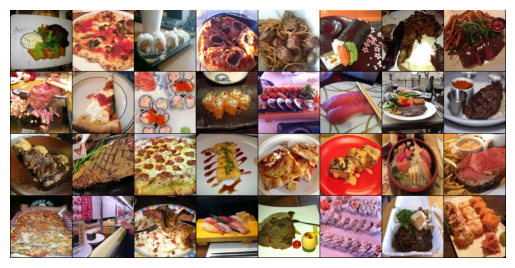

------------------------------------------------------------------------------------------------------------------------------------------------------


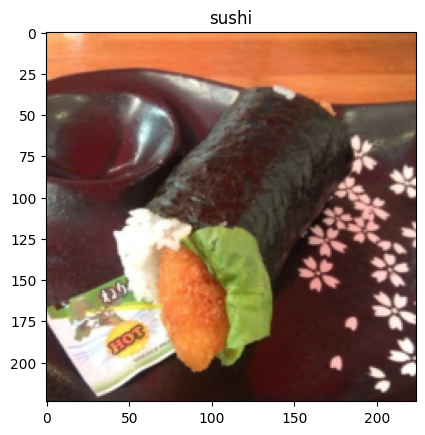

------------------------------------------------------------------------------------------------------------------------------------------------------


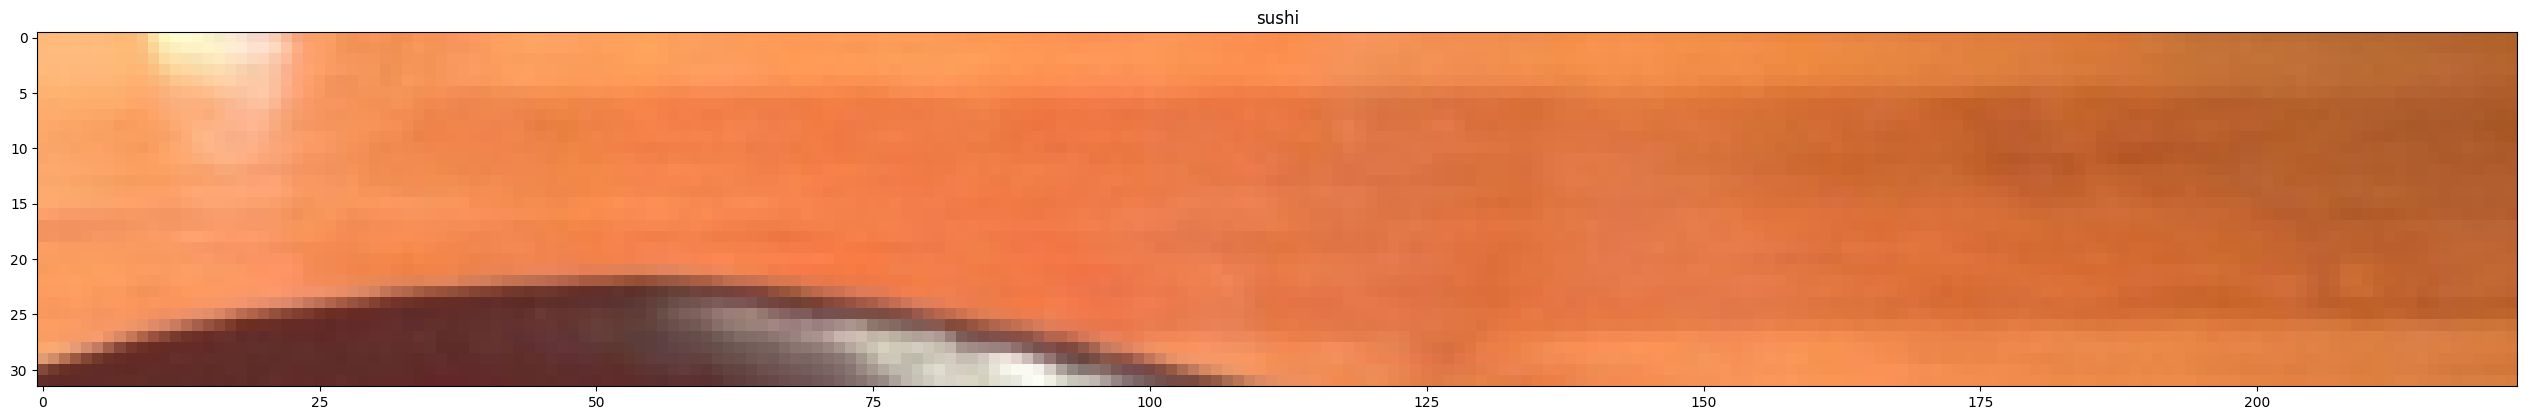

------------------------------------------------------------------------------------------------------------------------------------------------------
Number of patches of row:7.0
 Number of patches per column:7.0
Total Patches: 49.0
Patch size:32 pixels x 32 pixels


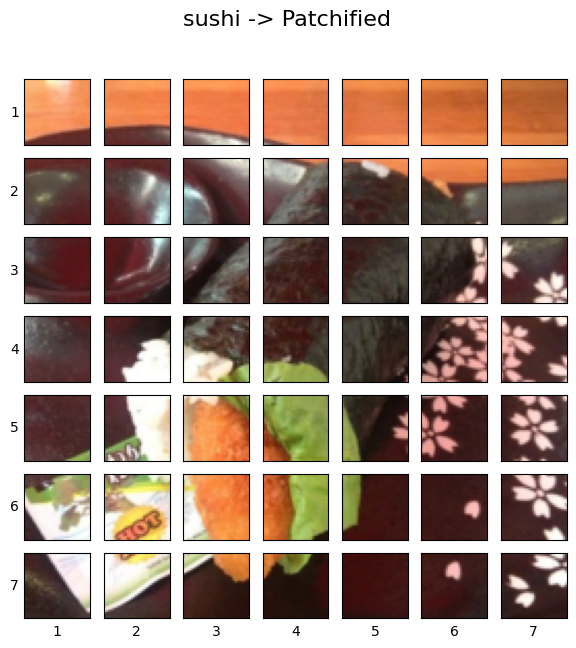

In [17]:
images,labels = next(iter(train_dataloader))

plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0).detach().cpu())
plt.axis(False)
plt.show()
print('-'*150)


img, label = images[5],labels[5]
original_img = img.permute(1,2,0).detach().cpu()
plt.imshow(original_img)
plt.title(class_names[label])
plt.show()

print('-'*150)
plt.figure(figsize=(PATCH_SIZE,PATCH_SIZE))
plt.imshow(original_img[:PATCH_SIZE,:,:])
plt.title(class_names[label])
plt.show()

print('-'*150)
NUMPATCHS = IMAGE_SIZE/PATCH_SIZE
assert IMAGE_SIZE%NUMPATCHS==0,"Image size must be divisible of NUM OF PATCHS"

plot_paticfied_image(original_img,label,class_names,patch_size=PATCH_SIZE)

In [18]:
model = ViT(num_classes=3,num_transformer_layer=NUM_TRASFORMER_LAYER,embeddig_dim=EMBEDDING_DIM,mlp_size=MLP_SIZE,num_heads=NUM_HEADS,patch_size=PATCH_SIZE)
model = model.apply(init_weights).to(DEVICE)

In [19]:
summary(model=model,input_size=(2,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [2, 3]                    52,224
├─PatchEmbedding: 1-1                              [2, 49, 1024]             --
│    └─Conv2d: 2-1                                 [2, 1024, 7, 7]           3,145,728
│    └─Flatten: 2-2                                [2, 1024, 49]             --
├─Dropout: 1-2                                     [2, 50, 1024]             --
├─Sequential: 1-3                                  [2, 50, 1024]             --
│    └─TransformerEncoderBlock: 2-3                [2, 50, 1024]             --
│    │    └─MultiheadSelfAttentionBlock: 3-1       [2, 50, 1024]             4,200,448
│    │    └─MLPBlock: 3-2                          [2, 50, 1024]             134,208
│    └─TransformerEncoderBlock: 2-4                [2, 50, 1024]             --
│    │    └─MultiheadSelfAttentionBlock: 3-3       [2, 50, 1024]             4,200,448
│    

In [20]:
optimizer:torch.optim.Optimizer =torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=0.9)
loss_fn:torch.nn.CrossEntropyLoss = torch.nn.CrossEntropyLoss(label_smoothing=0.3)

In [21]:
results = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,device=DEVICE,epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1 | train_loss:1.173925 | train_acc:0.281250 | test_loss:1.248765 | test_acc:0.260417
Epoch:2 | train_loss:1.151299 | train_acc:0.425781 | test_loss:1.269143 | test_acc:0.260417
Epoch:3 | train_loss:1.235329 | train_acc:0.300781 | test_loss:1.312897 | test_acc:0.197917
Epoch:4 | train_loss:1.246335 | train_acc:0.292969 | test_loss:1.312636 | test_acc:0.197917
Epoch:5 | train_loss:1.232389 | train_acc:0.296875 | test_loss:1.067108 | test_acc:0.541667
Epoch:6 | train_loss:1.124602 | train_acc:0.437500 | test_loss:1.071706 | test_acc:0.541667
Epoch:7 | train_loss:1.254296 | train_acc:0.281250 | test_loss:1.071263 | test_acc:0.541667
Epoch:8 | train_loss:1.217002 | train_acc:0.289062 | test_loss:1.060334 | test_acc:0.541667
Epoch:9 | train_loss:1.118867 | train_acc:0.406250 | test_loss:1.297430 | test_acc:0.197917
Epoch:10 | train_loss:1.234910 | train_acc:0.292969 | test_loss:1.209944 | test_acc:0.197917
Epoch:11 | train_loss:1.210129 | train_acc:0.285156 | test_loss:1.111048 | test

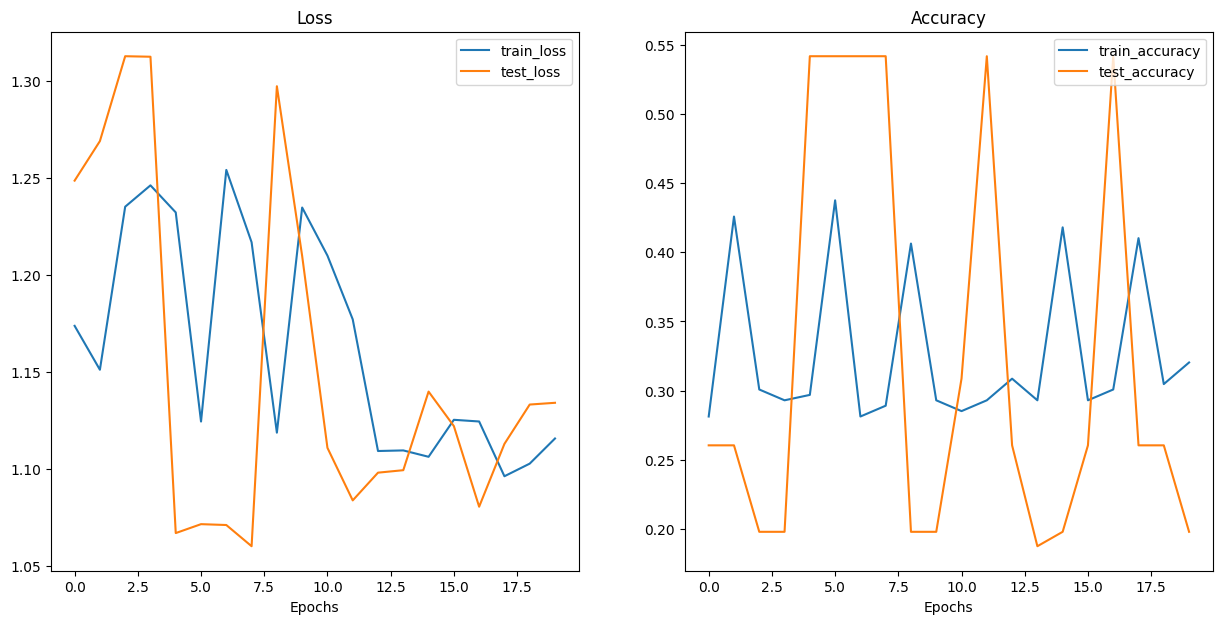

In [22]:
plot_loss_curves(results=results)

<h1 align='center'>Pretrained Weights</h1>

In [23]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=weights).to(DEVICE)
for p in pretrained_vit.parameters(): p.requires_grad = False

In [24]:
pretrained_vit.heads = torch.nn.Linear(768,3,bias=False,device=DEVICE)
summary(model=pretrained_vit,input_size=(2,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [2, 3]                    768
├─Conv2d: 1-1                                 [2, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [2, 197, 768]             151,296
│    └─Dropout: 2-1                           [2, 197, 768]             --
│    └─Sequential: 2-2                        [2, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [2, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [25]:
trainloader,testloader,class_names =create_dataloaders(train_dir=TRAIN_DIR,test_dir=TEST_DIR,transformation=weights.transforms(),batch_size=32,num_workers=1)

In [26]:
optimizer:torch.optim.Optimizer =torch.optim.Adam(pretrained_vit.parameters(),lr=3e-4,weight_decay=0.1) 

In [27]:
pretrained_results = train(model=pretrained_vit,train_dataloader=trainloader,test_dataloader=testloader,optimizer=optimizer,loss_fn=loss_fn,epochs=14,device=DEVICE)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch:1 | train_loss:1.089650 | train_acc:0.378906 | test_loss:0.976848 | test_acc:0.650568
Epoch:2 | train_loss:0.976411 | train_acc:0.621094 | test_loss:0.871615 | test_acc:0.815341
Epoch:3 | train_loss:0.834870 | train_acc:0.867188 | test_loss:0.809674 | test_acc:0.907197
Epoch:4 | train_loss:0.783491 | train_acc:0.917969 | test_loss:0.779751 | test_acc:0.887311
Epoch:5 | train_loss:0.752321 | train_acc:0.921875 | test_loss:0.761687 | test_acc:0.897727
Epoch:6 | train_loss:0.736175 | train_acc:0.933594 | test_loss:0.756490 | test_acc:0.897727
Epoch:7 | train_loss:0.740019 | train_acc:0.949219 | test_loss:0.751693 | test_acc:0.897727
Epoch:8 | train_loss:0.714494 | train_acc:0.953125 | test_loss:0.742362 | test_acc:0.908144
Epoch:9 | train_loss:0.706261 | train_acc:0.957031 | test_loss:0.739125 | test_acc:0.918561
Epoch:10 | train_loss:0.701753 | train_acc:0.960938 | test_loss:0.735611 | test_acc:0.918561
Epoch:11 | train_loss:0.700709 | train_acc:0.964844 | test_loss:0.733000 | test

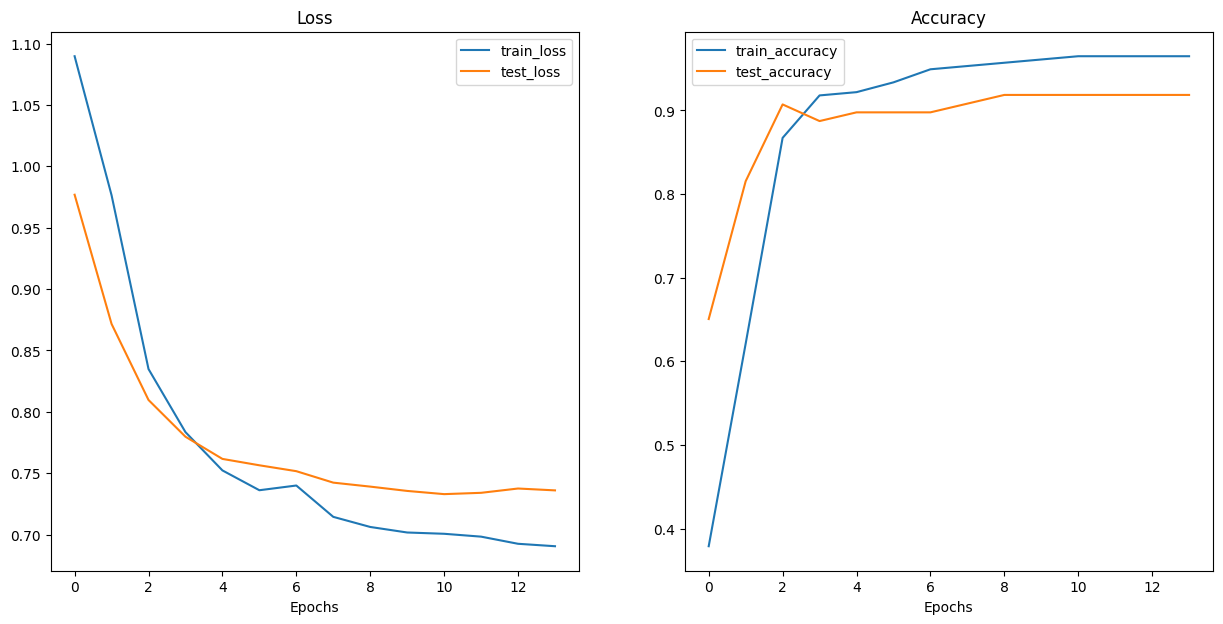

In [28]:
plot_loss_curves(results=pretrained_results)